# COVID-19 Mexican Analysis

### Needed libraries
**Note:** Run this part only if you don't have the libraries.

In [2]:
!pip3 install --upgrade pip setuptools numpy
!pip3 install pandas numpy zipfile37 xlrd openpyxl wget

### Importing the libraries

In [3]:
import pandas as pd
import zipfile
import json
import glob
import wget
import os
import re

In [4]:
with open(r'./configuration.json','r') as myFile:
    data = myFile.read()
info = json.loads(data)
myFile.close()

#### This function verifies the existance of the files in the folder

In [5]:
def checkFiles(fileName,files):
    flag = 0
    for file in files:
        if not re.search(fileName,file) == None:
            flag = 1
        else:
            flag = 0
    return flag, fileName

**If the Database doens't exist, then it download from the source**\
The following code downloads the latest dataset from the openacess database, this file is updated daily.

In [6]:
path = info.get('paths').get('Databases')
dataset = info.get('paths').get('dataset_url')
dictionary = info.get('paths').get('dictionary_url')
files = glob.glob(os.path.join(path,'*'))

[flag,fileName] = checkFiles(info.get('files').get('dataset_zip'),files)
if flag == 1:
    os.system('rm -r '+os.path.join(path,fileName))
    wget.download(dataset,path)
else:
    wget.download(dataset,path)

[flag,fileName] = checkFiles(info.get('files').get('dictionary_zip'),files)
if flag == 1:
    os.system('rm -r '+os.path.join(path,fileName))
    wget.download(dictionary,path)
else:
    wget.download(dictionary,path)

[flag,fileName] = checkFiles(info.get('files').get('open_data'),files)
if flag == 1:
    os.system('rm -r '+os.path.join(path,fileName))
[flag,fileName] = checkFiles(info.get('files').get('dictionary'),files)
if flag == 1:
    os.system('rm -r '+os.path.join(path,fileName))

**Extracting the information**\
Unzipping the downloaded files to be used and processed.

In [7]:
import zipfile
files = glob.glob(os.path.join(path,'*.zip'))
for file in files:
    if file == os.path.join(path,info.get('files').get('dictionary_zip')):
        with zipfile.ZipFile(file,"r") as zip_ref:
            zip_ref.extractall(os.path.join(path,dictionary.split('/')[len(dictionary.split('/'))-1].split('.')[0],'.'))
    else:
        with zipfile.ZipFile(file,"r") as zip_ref:
            zip_ref.extractall(os.path.join(path,'.'))

**Printing all the files**\
The function locates and print all the CSV files

In [8]:
def printFiles(files):
    counter = 0
    for file in files:
        print('['+str(counter)+']: ',file.split('/')[len(file.split('/'))-1])
        counter = counter + 1

In [9]:
files = glob.glob(os.path.join(path,'*.csv'))
printFiles(files)
db = pd.read_csv(files[0])
db.head()

[0]:  210429COVID19MEXICO.csv


,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2021-04-29,z482b8,1,12,9,2,9,9,12,1,...,2,2,97,2,97,1,99,México,97,97
1,2021-04-29,z49a69,1,12,23,1,23,23,4,2,...,1,2,97,2,97,2,99,México,97,1
2,2021-04-29,z23d9d,1,12,22,2,24,22,9,1,...,2,2,97,2,97,6,99,México,97,97
3,2021-04-29,z24953,1,12,9,1,9,9,10,1,...,1,1,2,2,97,7,99,México,97,97
4,2021-04-29,zz8e77,1,12,9,2,9,9,2,1,...,2,2,97,2,97,6,99,México,97,97


In [10]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6612450 entries, 0 to 6612449
Data columns (total 40 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   FECHA_ACTUALIZACION    object
 1   ID_REGISTRO            object
 2   ORIGEN                 int64 
 3   SECTOR                 int64 
 4   ENTIDAD_UM             int64 
 5   SEXO                   int64 
 6   ENTIDAD_NAC            int64 
 7   ENTIDAD_RES            int64 
 8   MUNICIPIO_RES          int64 
 9   TIPO_PACIENTE          int64 
 10  FECHA_INGRESO          object
 11  FECHA_SINTOMAS         object
 12  FECHA_DEF              object
 13  INTUBADO               int64 
 14  NEUMONIA               int64 
 15  EDAD                   int64 
 16  NACIONALIDAD           int64 
 17  EMBARAZO               int64 
 18  HABLA_LENGUA_INDIG     int64 
 19  INDIGENA               int64 
 20  DIABETES               int64 
 21  EPOC                   int64 
 22  ASMA                   int64 
 23  INMUSUP

## Transforming the data
The database are very large and it increases daily. However, the confirm cases are used for this analysis. In this database, the confirm cases also have other relations such as smoking, pneumonia, COPD, asthma, hyperthension, diabetes, among other complications. In this case, we are going to extract only the confirma cases by means of a laboratory analysis.

In [11]:
# Get positive COVID 19 infected people
#data = db.loc[(db['RESULTADO_LAB']==1)]
#data = db.loc[db['CLASIFICACION_FINAL'].isin([1,2,3])]
data = db
start_number = len(data)
print('Total registers: {:,.0f}'.format(len(data)))
data.head()

Total registers: 6,612,450


,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2021-04-29,z482b8,1,12,9,2,9,9,12,1,...,2,2,97,2,97,1,99,México,97,97
1,2021-04-29,z49a69,1,12,23,1,23,23,4,2,...,1,2,97,2,97,2,99,México,97,1
2,2021-04-29,z23d9d,1,12,22,2,24,22,9,1,...,2,2,97,2,97,6,99,México,97,97
3,2021-04-29,z24953,1,12,9,1,9,9,10,1,...,1,1,2,2,97,7,99,México,97,97
4,2021-04-29,zz8e77,1,12,9,2,9,9,2,1,...,2,2,97,2,97,6,99,México,97,97


**Let us extract the catalogue information to integrate it in the database, this will help to easy understand the parameters**

In [12]:
print(path)
os.system('rm -r '+os.path.join(path,'*.zip'))
files = glob.glob(os.path.join(path,'*/*'))
for file in files:
    if re.search('Catalogos',file) != None:
        break
catalogues = pd.ExcelFile(file)
catalogues.sheet_names

/Users/c.marcoa.roblesg./Documents/Projects/Data_Visualization_with_Tableau/M5_Data_Visualization_with_Tableau_Project/Week2/Databases


['Catálogo ORIGEN',
 'Catálogo SECTOR',
 'Catálogo SEXO',
 'Catálogo TIPO_PACIENTE',
 'Catálogo SI_NO',
 'Catálogo NACIONALIDAD',
 'Catálogo RESULTADO_LAB',
 'Catálogo RESULTADO_ANTIGENO',
 'Catálogo CLASIFICACION_FINAL',
 'Catálogo de ENTIDADES',
 'Catálogo MUNICIPIOS']

**In this part, the catalogue is open and merge to the database**\
**ORIGIN Catalogue**\
It describes the origin description.

|Code|Descriptio|
|----|----------|
| 1  | USMER    |
| 2  | Out of USMER |
| 99 | Not specify |

Sentinel surveillance is carried out through the system of respiratory disease monitoring units (USMER). The USMER includes medical units of the first, second or third level of care, and third level units also participate as USMERs, which due to their characteristics contribute to expanding the epidemiological information panorama, including those with a specialty in pulmonology, infectology or pediatrics.



In [13]:
origen = catalogues.parse('Catálogo ORIGEN')
data = data.join(origen.set_index(['CLAVE']),on=['ORIGEN'])
data = data.rename(columns={'DESCRIPCIÓN':'ORIGEN_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


**SECTOR CATALOGUE**

Identify the type of institution of the National Health System that provided the care.

| Code | Description |
|------|-------------|
| 1	| CRUZ ROJA|
|2	| DIF |
|3	| ESTATAL |
|4	| IMSS |
|5	| IMSS-BIENESTAR |
|6	| ISSSTE |
|7	| MUNICIPAL|
|8	| PEMEX|
|9	| PRIVADA|
|10	| SEDENA|
|11	| SEMAR|
|12	| SSA|
|13	| UNIVERSITARIO|
|99	| NO ESPECIFICADO |

In [14]:
sector = catalogues.parse('Catálogo SECTOR')
data = data.join(sector.set_index(['CLAVE']),on=['SECTOR'])
data = data.rename(columns={'DESCRIPCIÓN':'SECTOR_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


**GENDER**

| CODE |	DESCRIPTION|
|-|-|
|1|	MUJER|
|2|	HOMBRE|
|99|	NO ESPECIFICADO|


In [15]:
sexo = catalogues.parse('Catálogo SEXO')
data = data.join(sexo.set_index(['CLAVE']),on=['SEXO'])
data = data.rename(columns={'DESCRIPCIÓN':'SEXO_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


**Type of Patient**

Classify a patient by its status, if it is set to a hospital or it is not necesary to stay there.

|CODE	| DESCRIPTION|
|-|-|
|1|	AMBULATORIO|
|2|	HOSPITALIZADO|
|99|	NO ESPECIFICADO|

In [16]:
tipoPaciente = catalogues.parse('Catálogo TIPO_PACIENTE')
data = data.join(tipoPaciente.set_index(['CLAVE']),on=['TIPO_PACIENTE'])
data = data.rename(columns={'DESCRIPCIÓN':'TIPO_PACIENTE_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


**Nationality**

Classify the patient by its nationality

|CODE|	DESCRIPTION|
|-|-|
|1	|MEXICANA|
|2	|EXTRANJERA|
|99	|NO ESPECIFICADO|

In [17]:
nacionalidad = catalogues.parse('Catálogo NACIONALIDAD')
data = data.join(nacionalidad.set_index(['CLAVE']),on=['NACIONALIDAD'])
data = data.rename(columns={'DESCRIPCIÓN':'NACIONALIDAD_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


**Medical Analysis**

This is the most important classification, because it identifies the personn as infected or healthy.

|CODE|	DESCRIPTION|
|-|-|
|1|	POSITIVO A SARS-COV-2|
|2|	NO POSITIVO A SARS-COV-2|
|3|	RESULTADO PENDIENTE|
|4|	RESULTADO NO ADECUADO |
|97|	NO APLICA (CASO SIN MUESTRA)|

In [18]:
resultadoLab = catalogues.parse('Catálogo RESULTADO_LAB',1)
data = data.join(resultadoLab.set_index(['CLAVE']),on=['RESULTADO_LAB'])
data = data.rename(columns={'DESCRIPCIÓN':'RESULTADO_LAB_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


**Final Classification**

It checks and compare the status with the medical appointment.

|CODE|	CLASIFICATION|	DESCRIPTION|
|-|-|-|
|1|	CASO DE COVID-19 CONFIRMADO POR ASOCIACIÓN CLÍNICA EPIDEMIOLÓGICA|	"Confirmado por asociación aplica cuando el caso informó ser contacto de un positivo a COVID-19 (y este se encuentra registrado en el SISVER) y: Al caso no se le tomo muestra o la muestra resultó no válida. "|
|2|	CASO DE COVID-19 CONFIRMADO POR COMITÉ DE  DICTAMINACIÓN|	"Confirmado por dictaminación solo aplica para defunciones bajo las siguientes condiciones: Al caso no se le tomo muestra o sí se tomó muestra, pero la muestra resultó no válida. "|
|3|	CASO DE SARS-COV-2  CONFIRMADO POR LABORATORIO|	"Confirmado por laboratorio aplica cuando: El caso tiene muestra y resultó positiva  a SARS-CoV-2, sin importar si el caso tienen asociación clínica epidemiológica."|
|4	|INVÁLIDO POR LABORATORIO|	Inválido aplica cuando el caso no tienen asociación clínico epidemiológica, ni dictaminación a COVID-19. Se le tomó muestra y esta resultó no válida. |
|5	|NO REALIZADO POR LABORATORIO	|No realizado aplica cuando el caso no tienen asociación clínico epidemiológica, ni dictaminación a COVID-19 y se le tomó muestra y esta no se procesó.|
|6	|CASO SOSPECHOSO|	"Sospechoso aplica cuando: El caso no tienen asociación clínico epidemiológica, ni dictaminación a COVID-19 y no se le tomó muestra, o se le tomó muestra y está pendiente de resultado, sin importar otra condición."|
|7	|NEGATIVO A SARS-COV-2 POR LABORATORIO|	"Negativo aplica cuando el caso:Se le tomo muestra y esta resultó: negativa a SARS-COV-2 o positiva a cualquier otro virus respiratorio (Influenza, VSR, Bocavirus, otros) sin importar que este caso tenga asociación clínico epidemiológica o dictaminación a COVID-19."|

In [19]:
classificacion_final = catalogues.parse('Catálogo CLASIFICACION_FINAL',2)
data = data.join(classificacion_final.set_index(['CLAVE']),on=['CLASIFICACION_FINAL'])
data = data.rename(columns={'DESCRIPCIÓN':'CLAS_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


**Entities Catalogue**\
All the states that present someone infected.\
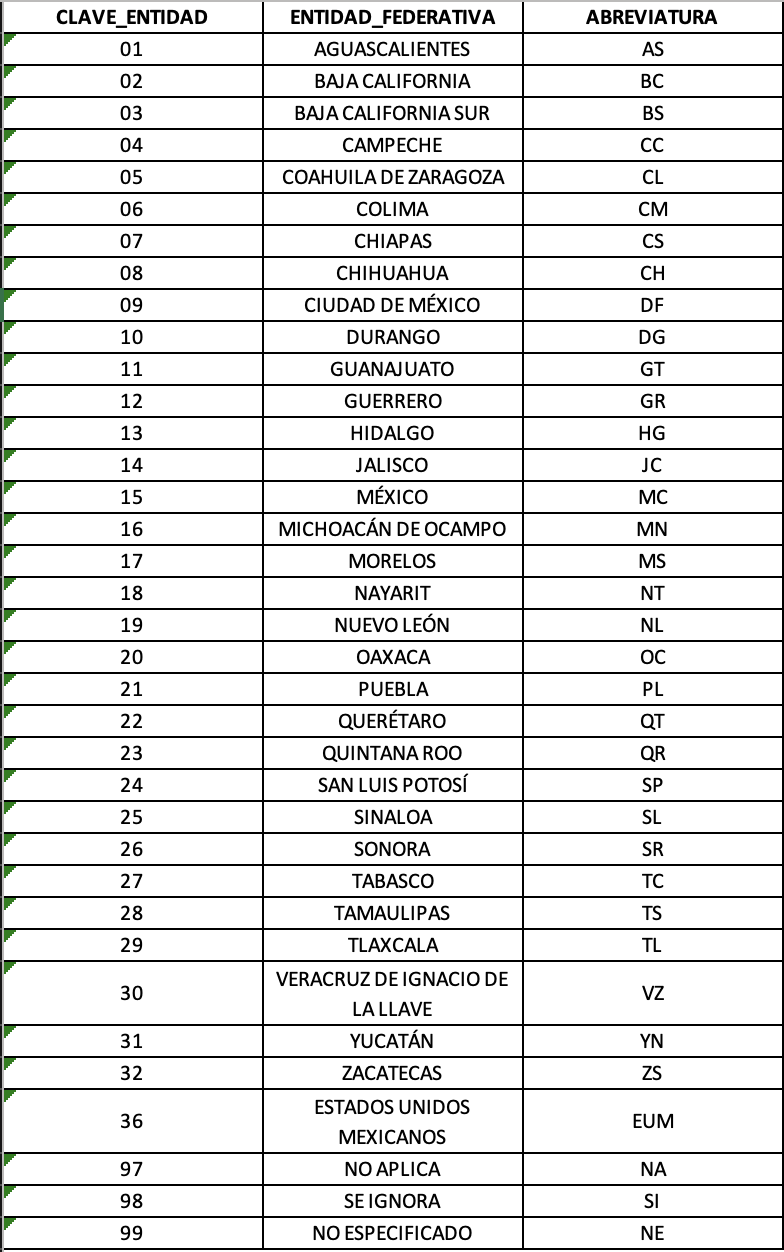

In [20]:
entidades = catalogues.parse('Catálogo de ENTIDADES')
data = data.join(entidades.set_index(['CLAVE_ENTIDAD']),on=['ENTIDAD_NAC'])
data = data.rename(columns={'ENTIDAD_FEDERATIVA':'ENTIDAD_FEDERATIVA_NAC','ABREVIATURA':'ABREVIATURA_NAC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [21]:
entidades = catalogues.parse('Catálogo de ENTIDADES')
data = data.join(entidades.set_index(['CLAVE_ENTIDAD']),on=['ENTIDAD_RES'])
data = data.rename(columns={'ENTIDAD_FEDERATIVA':'ENTIDAD_FEDERATIVA_RES','ABREVIATURA':'ABREVIATURA_RES'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [22]:
entidades = catalogues.parse('Catálogo de ENTIDADES')
data = data.join(entidades.set_index(['CLAVE_ENTIDAD']),on=['ENTIDAD_UM'])
data = data.rename(columns={'ENTIDAD_FEDERATIVA':'ENTIDAD_FEDERATIVA_UM','ABREVIATURA':'ABREVIATURA_UM'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


**Yes or no catalogue**\
Depending on the column it shows a result.\
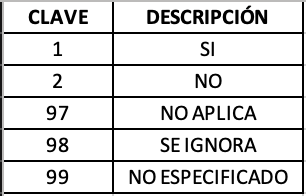

In [23]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['INTUBADO'])
data = data.rename(columns={'DESCRIPCIÓN':'INTUBADO_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [24]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['NEUMONIA'])
data = data.rename(columns={'DESCRIPCIÓN':'NEUMONIA_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [25]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['HABLA_LENGUA_INDIG'])
data = data.rename(columns={'DESCRIPCIÓN':'HABLA_LENGUA_INDIG_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [26]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['INDIGENA'])
data = data.rename(columns={'DESCRIPCIÓN':'INDIGENA_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [27]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['DIABETES'])
data = data.rename(columns={'DESCRIPCIÓN':'DIABETES_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [28]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['EPOC'])
data = data.rename(columns={'DESCRIPCIÓN':'EPOC_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [29]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['ASMA'])
data = data.rename(columns={'DESCRIPCIÓN':'ASMA_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [30]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['INMUSUPR'])
data = data.rename(columns={'DESCRIPCIÓN':'INMUSUPR_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [31]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['OTRA_COM'])
data = data.rename(columns={'DESCRIPCIÓN':'OTRA_COM_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [32]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['CARDIOVASCULAR'])
data = data.rename(columns={'DESCRIPCIÓN':'CARDIOVASCULAR_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [33]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['OBESIDAD'])
data = data.rename(columns={'DESCRIPCIÓN':'OBESIDAD_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [34]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['RENAL_CRONICA'])
data = data.rename(columns={'DESCRIPCIÓN':'RENAL_CRONICA_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [35]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['TABAQUISMO'])
data = data.rename(columns={'DESCRIPCIÓN':'TABAQUISMO_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [36]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['OTRO_CASO'])
data = data.rename(columns={'DESCRIPCIÓN':'OTRO_CASO_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [37]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['TOMA_MUESTRA_LAB'])
data = data.rename(columns={'DESCRIPCIÓN':'TOMA_MUESTRA_LAB_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [38]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['TOMA_MUESTRA_ANTIGENO'])
data = data.rename(columns={'DESCRIPCIÓN':'TOMA_MUESTRA_ANTIGENO_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [39]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['MIGRANTE'])
data = data.rename(columns={'DESCRIPCIÓN':'MIGRANTE_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [40]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['UCI'])
data = data.rename(columns={'DESCRIPCIÓN':'UCI_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [41]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['HIPERTENSION'])
data = data.rename(columns={'DESCRIPCIÓN':'HIPERTENSION_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [42]:
si_no = catalogues.parse('Catálogo SI_NO')
data = data.join(si_no.set_index(['CLAVE']),on=['EMBARAZO'])
data = data.rename(columns={'DESCRIPCIÓN':'EMBARAZO_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [43]:
municipios = catalogues.parse('Catálogo MUNICIPIOS')
data = data.join(municipios.set_index(['CLAVE_MUNICIPIO','CLAVE_ENTIDAD']),on=['MUNICIPIO_RES','ENTIDAD_RES'])
data = data.rename(columns={'DESCRIPCIÓN':'MUNICIPIO_RES_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [44]:
antigeno = catalogues.parse('Catálogo RESULTADO_ANTIGENO',header=1)
data = data.join(antigeno.set_index(['CLAVE']),on=['RESULTADO_ANTIGENO'])
data = data.rename(columns={'DESCRIPCIÓN':'RESULTADO_ANTIGENO_DESC'})
print('Total registers: {:,.0f}'.format(len(data)),'\nStarting register number: {:,.0f}'.format(start_number))

Total registers: 6,612,450 
Starting register number: 6,612,450


In [45]:
data.loc[(data['PAIS_ORIGEN'].isin(['97'])),'PAIS_ORIGEN'] = data.loc[(data['PAIS_ORIGEN'].isin(['97'])),'PAIS_NACIONALIDAD']

**Change the date 9999-99-99 to Alive**

In [46]:
import datetime

data['FECHA_INGRESO'] = pd.to_datetime(data['FECHA_INGRESO'])
data.loc[(data['FECHA_DEF'].isin(['9999-99-99'])),'Status'] = 'Alive'
data.loc[(~data['FECHA_DEF'].isin(['9999-99-99'])),'Status'] = 'Dead'

today = datetime.datetime.now()
delta_time = datetime.timedelta(days = 15)
newDate = today - delta_time
data.loc[(data['FECHA_DEF'].isin(['9999-99-99'])) & (data['FECHA_INGRESO']>pd.to_datetime(newDate.date())) & (data['TIPO_PACIENTE_DESC'].isin(['AMBULATORIO'])),'Status']='Active'

today = datetime.datetime.now()
delta_time = datetime.timedelta(days = 25)
newDate = today - delta_time
data.loc[(data['FECHA_DEF'].isin(['9999-99-99'])) & (data['FECHA_INGRESO']>pd.to_datetime(newDate.date())) & (data['TIPO_PACIENTE_DESC'].isin(['HOSPITALIZADO'])),'Status']='Active'

**Change the column to datetime format**

In [47]:
data['FECHA_INGRESO'] = pd.to_datetime(data['FECHA_INGRESO'])
data['FECHA_SINTOMAS'] = pd.to_datetime(data['FECHA_SINTOMAS'])

**Extract the month from the datetime analysis**

In [48]:
data['MES_ING'] = data['FECHA_INGRESO'].dt.month
data['MES_SINTOMAS'] = data['FECHA_SINTOMAS'].dt.month
data['MES_DEF'] = data['FECHA_DEF'].str.split('-',expand=True)[1].astype(int)

**Saving the result into a csv file**

In [49]:
data.loc[(data['EDAD']<5),'EDAD_CLASS'] = 'Baby'
data.loc[(data['EDAD'].between(5,8)),'EDAD_CLASS'] = 'Child'
data.loc[(data['EDAD'].between(9,17)),'EDAD_CLASS'] = 'Teenage'
data.loc[(data['EDAD'].between(18,30)),'EDAD_CLASS'] = 'Young Adult'
data.loc[(data['EDAD'].between(31,60)),'EDAD_CLASS'] = 'Adult'
data.loc[(data['EDAD']>60),'EDAD_CLASS'] = 'Senior Adult'

In [50]:
data.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,UCI_DESC,HIPERTENSION_DESC,EMBARAZO_DESC,MUNICIPIO,RESULTADO_ANTIGENO_DESC,Status,MES_ING,MES_SINTOMAS,MES_DEF,EDAD_CLASS
0,2021-04-29,z482b8,1,12,9,2,9,9,12,1,...,NO APLICA,NO,NO APLICA,TLALPAN,NO APLICA (CASO SIN MUESTRA),Alive,10,10,99,Adult
1,2021-04-29,z49a69,1,12,23,1,23,23,4,2,...,SI,SI,NO,OTHÓN P. BLANCO,NO APLICA (CASO SIN MUESTRA),Dead,7,7,7,Senior Adult
2,2021-04-29,z23d9d,1,12,22,2,24,22,9,1,...,NO APLICA,NO,NO APLICA,JALPAN DE SERRA,NO APLICA (CASO SIN MUESTRA),Alive,1,1,99,Young Adult
3,2021-04-29,z24953,1,12,9,1,9,9,10,1,...,NO APLICA,NO,SE IGNORA,ÁLVARO OBREGÓN,NO APLICA (CASO SIN MUESTRA),Alive,10,10,99,Adult
4,2021-04-29,zz8e77,1,12,9,2,9,9,2,1,...,NO APLICA,NO,NO APLICA,AZCAPOTZALCO,NO APLICA (CASO SIN MUESTRA),Alive,4,4,99,Adult


In [51]:
data.loc[(data['CLASIFICACION_FINAL'].isin([1,2,3])),'Lab_Status'] = 'Positive'
data.loc[(data['CLASIFICACION_FINAL'].isin([4,5])),'Lab_Status'] = 'Invalid'
data.loc[(data['CLASIFICACION_FINAL'].isin([6])),'Lab_Status'] = 'Suspicious'
data.loc[(data['CLASIFICACION_FINAL'].isin([7])),'Lab_Status'] = 'Negative'

In [52]:
data.loc[(data['CLASIFICACION_FINAL'].isin([4,5,6,7])),'Status'] = 'Negative'

In [53]:
os.system('rm -r ../Databases/*')
data.to_csv(os.path.join(path,'full_covid_dataset.csv'),index=False,encoding='utf-8',line_terminator='\n')

In [54]:
os.system('zip ../Databases/full_db.zip ../Databases/full_covid_dataset.csv')

0

In [55]:
db = data[(data['CLASIFICACION_FINAL'].isin([1,2,3]))]
db = db.drop(columns=['ORIGEN','SECTOR','SEXO','TIPO_PACIENTE','NACIONALIDAD',
                          'RESULTADO_LAB','CLASIFICACION_FINAL','ENTIDAD_NAC',
                          'ENTIDAD_RES','ENTIDAD_UM','INTUBADO','NEUMONIA',
                          'HABLA_LENGUA_INDIG','INDIGENA','DIABETES','EPOC',
                          'ASMA','INMUSUPR','OTRA_COM','CARDIOVASCULAR','OBESIDAD',
                          'RENAL_CRONICA','TABAQUISMO','OTRO_CASO','TOMA_MUESTRA_LAB',
                          'TOMA_MUESTRA_ANTIGENO','MIGRANTE','UCI','HIPERTENSION',
                          'MUNICIPIO_RES','EMBARAZO','RESULTADO_ANTIGENO'],axis=1)

In [56]:
db.to_csv(os.path.join(path,'mex_covid_daily.csv'),index=False,encoding='utf-8',line_terminator='\n')

In [57]:
os.system('zip ../Databases/db.zip ../Databases/mex_covid_daily.csv')
os.system('rm -r ../Databases/*.csv')

0

In [58]:
data.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_LAB',
       'TOMA_MUESTRA_ANTIGENO', 'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI', 'ORIGEN_DESC',
       'SECTOR_DESC', 'SEXO_DESC', 'TIPO_PACIENTE_DESC', 'NACIONALIDAD_DESC',
       'RESULTADO_LAB_DESC', 'CLASIFICACIÓN', 'CLAS_DESC',
       'ENTIDAD_FEDERATIVA_NAC', 'ABREVIATURA_NAC', 'ENTIDAD_FEDERATIVA_RES',
       'ABREVIATURA_RES', 'ENTIDAD_FEDERATIVA_UM', 'ABREVIATURA_UM',
       'INTUBADO_DESC', 'NEUMONIA_DESC', 'HABLA_

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6612450 entries, 0 to 6612449
Data columns (total 82 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   FECHA_ACTUALIZACION         object        
 1   ID_REGISTRO                 object        
 2   ORIGEN                      int64         
 3   SECTOR                      int64         
 4   ENTIDAD_UM                  int64         
 5   SEXO                        int64         
 6   ENTIDAD_NAC                 int64         
 7   ENTIDAD_RES                 int64         
 8   MUNICIPIO_RES               int64         
 9   TIPO_PACIENTE               int64         
 10  FECHA_INGRESO               datetime64[ns]
 11  FECHA_SINTOMAS              datetime64[ns]
 12  FECHA_DEF                   object        
 13  INTUBADO                    int64         
 14  NEUMONIA                    int64         
 15  EDAD                        int64         
 16  NACIONALIDAD      

In [60]:
data['Lab_Status'].unique()

array(['Positive', 'Suspicious', 'Negative', 'Invalid'], dtype=object)